# Sudoku Solver


We consider the $n=2$ case of a Sudoku puzzle. The input is a $4\times 4$ array of integers from 0 to 4, with 0 denoting the empty cells. The output is the solved puzzle, along with the probability that the solution is correct.

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
from IPython.display import display

import numpy as np

## From puzzle to empty quantum circuit
In this section we define the functions to create our oracle. The main function creates an empty quantum circuit corresponding to the original puzzle. This function currently accepts any size list of lists. 

### To test the code
Input a test puzzle of your choice. Currently, the code will only work with a 4x4 solvable sudoku puzzle. Much of the notebook extends to arbitrary size or a potentialy unsolvable puzzle, but some additions are necessary for full functionality.

In [ ]:
#Here is the test puzzle for our functions
test_puzzle = [[1, 0, 0, 4], [3, 0, 1, 0],[0, 1, 0, 3],[4, 0, 2, 1]]

In [4]:
puzzle_size = 2

#The oracle needs to know what the puzzle is! These functions should work for an arbitrary size puzzle.

def puzzle_constraints(puzzle: list[list[int]]):
    constraints = {}
    for i in range(len(puzzle)):
        constraints.update({f"row{i}" : [puzzle[i][j] for j in range(len(puzzle)) if puzzle[i][j]!=0]}) #parsing the row values
        constraints.update({f"col{i}" : [puzzle[j][i] for j in range(len(puzzle)) if puzzle[j][i]!=0]}) #parsing the column values
    for i in range(puzzle_size):
        for j in range(puzzle_size): #parsing the square values
            square_list=[]
            for a in range(puzzle_size):
                for b in range(puzzle_size):
                    if puzzle[puzzle_size*i+a][puzzle_size*j+b]!=0:
                        square_list.append(puzzle[puzzle_size*i+a][puzzle_size*j+b])
            constraints.update({f"square{i}{j}" : square_list}) #parsing the square values
    comparisons = {}
    max_comp = 0
    for area, vals in constraints.items():
        e = len(puzzle) - len(vals)            # # of empty cells in that area
        comp = e * len(vals) + (e*(e-1)) // 2
        comparisons[area] = comp
        if comp > max_comp:
            max_comp = comp

    return constraints, max_comp  #Output of this function is an ordered pair of a constraint dictionary and the maximum number of comparisons for an area.

#This function returns a list of the empty cells (we will want to iterate over this list.)
def empty_cells_fn(puzzle: list[list[int]]): #input puzzle as a list of lists
    empty_cells = [] # a list of the "empty" cells from the original puzzle by row and column
    for row in range(puzzle_size**2):
        for column in range(puzzle_size**2):
            if puzzle[row][column] == 0:
                empty_cells.append((row,column))
    return empty_cells
    
# We will also need lists of the (row, column) indices for each square.for i in range(puzzle_size):
def square_list_fn(puzzle_size: int): 
    square_list = {} 
    for i in range(puzzle_size):  
        for j in range(puzzle_size): #parsing the square values
            square_list_vals=[]
            for a in range(puzzle_size):
                for b in range(puzzle_size):
                    square_list_vals.append((puzzle_size*i+a,puzzle_size*j+b))
            square_list.update({f"square{i}{j}" : square_list_vals}) #listing the square indices for later iterations
    return square_list

### Getting local area information
Since we will be solving the puzzle by considering each row, column and square, we need a helper function to extract the local empty cells and constraints.

In [6]:
def area_dict_fn(puzzle: list[list[int]],size: int):
    if size*size != len(puzzle):
        print("Puzzle size does not match puzzle")
        return 0
    else: #Now that we know the puzzle size matches the puzzle, we build the dictionary
        constraints = puzzle_constraints(puzzle)
        constraint_dic = constraints[0] # the dictionary of constraints
        area_dict = {} #We construct a dictionary for all cells in each area
        for i in range(size*size): #Getting the rows
            area_dict[f"row{i}"] = [(i,j) for j in range(size*size)]
        for j in range(size*size): #Getting the columns
            area_dict[f"col{j}"] = [(i,j) for i in range(size*size)] 
        area_dict.update(square_list_fn(size))
        empties = set(empty_cells_fn(puzzle))
        local_constraints = {}
        local_empty_cells    = {}
        for area, cells in area_dict.items():
            local_constraints[area] = constraint_dic[area]
            local_empty_cells[area]     = [c for c in cells if c in empties]

        return local_constraints, local_empty_cells


 


        

### Test the function

In [7]:
test = area_dict_fn(test_puzzle,2)
test

({'row0': [1, 4],
  'row1': [3, 1],
  'row2': [1, 3],
  'row3': [4, 2, 1],
  'col0': [1, 3, 4],
  'col1': [1],
  'col2': [1, 2],
  'col3': [4, 3, 1],
  'square00': [1, 3],
  'square01': [4, 1],
  'square10': [1, 4],
  'square11': [3, 2, 1]},
 {'row0': [(0, 1), (0, 2)],
  'row1': [(1, 1), (1, 3)],
  'row2': [(2, 0), (2, 2)],
  'row3': [(3, 1)],
  'col0': [(2, 0)],
  'col1': [(0, 1), (1, 1), (3, 1)],
  'col2': [(0, 2), (2, 2)],
  'col3': [(1, 3)],
  'square00': [(0, 1), (1, 1)],
  'square01': [(0, 2), (1, 3)],
  'square10': [(2, 0), (3, 1)],
  'square11': [(2, 2)]})

In [24]:
#Now the function that builds the main circuit for our sudoku solution
def build_sudoku_circuit(puzzle: list[list[int]]): #input puzzle as a list of lists 
    empty_cells = empty_cells_fn(puzzle)
    empty_cell_registers = { } # a dictionary mapping to a 2 qubit register for each empty cell
    for (row,column) in empty_cells:
        qreg_name = f"r{row}_c{column}" #quantum register for the empty cell
        qr = QuantumRegister(2, name=qreg_name) 
        # 2 bits for the digit. This size needs to be adjusted for a generic puzzle because digits will take more than 2 qubits
        empty_cell_registers [(row, column)] = qr
    cfl_count = 9 # This is because the maximum number of comparisons is 6 when n=2. Needs updating to generalize
    ancillary_calcbits = QuantumRegister(cfl_count, name = "calc") # This size needs to be adjusted for a generic puzzle. 
    ancillary_areas = QuantumRegister(3*puzzle_size**2, name = "arow") # 12 ancillary qubits to check rows, columns, and squares
    allregisters =  list(empty_cell_registers.values()) + [ancillary_calcbits] +[ancillary_areas] 
    qc = QuantumCircuit(*allregisters, name="Sudoku_Circuit")
    
    return qc, empty_cell_registers, ancillary_calcbits, ancillary_areas
# Function returns the quantum circuit and all of the associated registers



## Example use of functions with test puzzle

    [1, 0, 0, 4],
    [3, 0, 1, 0],
    [0, 1, 0, 3],
    [4, 0, 2, 1]

In [9]:
sudoku_qc_test = build_sudoku_circuit(test_puzzle)
sudoku_qc_test

(<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x10ca3f690>,
 {(0, 1): QuantumRegister(2, 'r0_c1'),
  (0, 2): QuantumRegister(2, 'r0_c2'),
  (1, 1): QuantumRegister(2, 'r1_c1'),
  (1, 3): QuantumRegister(2, 'r1_c3'),
  (2, 0): QuantumRegister(2, 'r2_c0'),
  (2, 2): QuantumRegister(2, 'r2_c2'),
  (3, 1): QuantumRegister(2, 'r3_c1')},
 QuantumRegister(9, 'calc'),
 QuantumRegister(12, 'arow'))

In [10]:
#get the square_list dictionary
#This function may not be used for the 4x4 puzzle, but would be needed for generalizing.
squares = square_list_fn(puzzle_size)
squares

{'square00': [(0, 0), (0, 1), (1, 0), (1, 1)],
 'square01': [(0, 2), (0, 3), (1, 2), (1, 3)],
 'square10': [(2, 0), (2, 1), (3, 0), (3, 1)],
 'square11': [(2, 2), (2, 3), (3, 2), (3, 3)]}

In [11]:
# test the constraint function with the test puzzle
puzzle_info = puzzle_constraints(test_puzzle)
puzzle_info


({'row0': [1, 4],
  'col0': [1, 3, 4],
  'row1': [3, 1],
  'col1': [1],
  'row2': [1, 3],
  'col2': [1, 2],
  'row3': [4, 2, 1],
  'col3': [4, 3, 1],
  'square00': [1, 3],
  'square01': [4, 1],
  'square10': [1, 4],
  'square11': [3, 2, 1]},
 6)

### Here is the test puzzle again to compare:

    [1, 0, 0, 4],
    [3, 0, 1, 0],
    [0, 1, 0, 3],
    [4, 0, 2, 1]

## Oracle Helper Gates

In this  section, we are setting up the gates that will detect conflicts with the given puzzle. We want a reversible circuit that will detect whether two qubits in the row corresponding to empty cells encode the same value or any of the empty cell qubits encode a value given as a constant of the puzzle. We will record a +1 in the ancillary bit corresponding to that row if and only if there are no conflicts. 

The first step to build this circuit is a comparison gate between two registers, each corresponding to an unknow value in the puzzle.

These gates are constructured to be self-inverses.

### Compare Two Qubits Gate

In [12]:
#Comparison circuit that flips a conflict bit if two registers, A and B, are equal. We will use this as a gate in our oracle.

qr_A = QuantumRegister(2, "a")
qr_B = QuantumRegister(2, "b")
tmp = QuantumRegister(2,"t")
conflict = QuantumRegister(1,"cf")

compare_qubits_circuit = QuantumCircuit(qr_A,qr_B,tmp,conflict, name = "Compare Qubits")
compare_qubits_circuit.cx(qr_A[0],tmp[0]) # These four CX gates compute an XOR of the two registers in the tmp register
compare_qubits_circuit.cx(qr_A[1],tmp[1])
compare_qubits_circuit.cx(qr_B[0],tmp[0])
compare_qubits_circuit.cx(qr_B[1],tmp[1])
compare_qubits_circuit.x(tmp[0]) # These two X gates flip the tmp bits to be both 1 if and only if the two registers agree. 
compare_qubits_circuit.x(tmp[1])
compare_qubits_circuit.ccx(tmp[0],tmp[1],conflict[0]) # The conflict bit is set to 1 if and only if the two registers agree.
# Now we reset the tmp bits to 0 the order doesn't matter for these operators, but we'll put it in reverse for good measure.
compare_qubits_circuit.x(tmp[1])
compare_qubits_circuit.x(tmp[0])
compare_qubits_circuit.cx(qr_B[1],tmp[1])
compare_qubits_circuit.cx(qr_B[0],tmp[0])
compare_qubits_circuit.cx(qr_A[1],tmp[1])
compare_qubits_circuit.cx(qr_A[0],tmp[0])



CompReg = compare_qubits_circuit.to_gate() 
# Gate requirements: 7 wires
# 2 wires each for 2 quantum register
# 2 zero set wires. 
# 1 recording wire
# The first two are used for tmp and exit gate at zero
# The last wire has a bit flip exactly when there is a conflict.






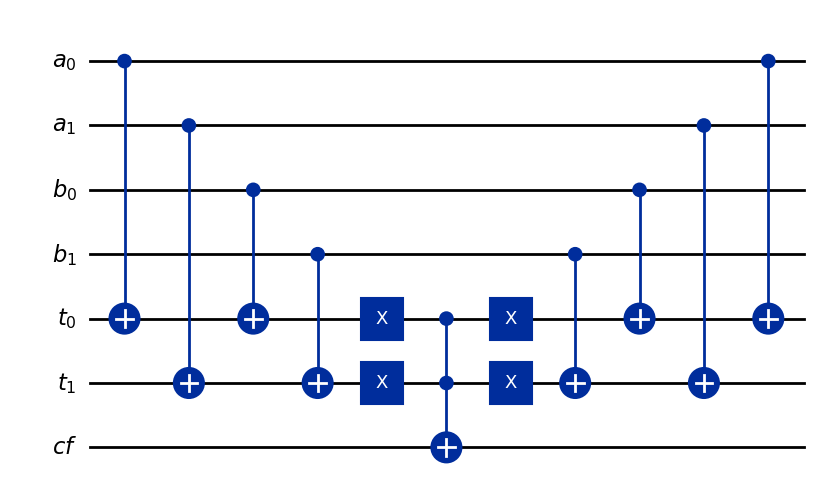

In [13]:
compare_qubits_circuit.draw("mpl")

In [14]:
#Test the gate
test_qr = QuantumRegister(4, "x")
test_ar = AncillaRegister(3, "a")
test_qc = QuantumCircuit(test_qr, test_ar)
test_qc.h(test_qr)
test_qc.compose(CompReg, inplace = True)
#test_qc.draw(output = "mpl")  #uncomment this line and comment out the one below to see the drawn circuit instead.
psi = Statevector(test_qc)
psi
psi.draw("latex")


<IPython.core.display.Latex object>

We see that the control bit is flipped to 1 exactly when the the two quantum registers coincide, and the two ancillary wires are reset to zero.

### Compare to Known Integer Gate
The next gate will compare a register against a known binary number. 


In [20]:
#We define a function that will create this circuit for a given integer. 
#The function takes as arguments the known integer and a quatum register with 5 wires.
# The top two wires are the qubit to be compared. 
# The next two wires are assumed to arrive as zeros and will be set to the known integer. 
# The final wire is a conflict detection wire, this bit is flipped if there is a conflict.

def int_to_binary_list(n: int): #small helper function to give a list of bits to apply to my wires.
    return [int(bit) for bit in bin(n)[2:]]


def compare_to_int(known: int): # This is built assuming that the puzzle is SIZE 4x4
    
    if known > 4 or known < 1: # Give an error if the number is not a valid sukdoku entry
        return print("Invalid integer. Input a number from 1-4")
    clabel =f"Compare{known}"
    known = known%4 # converting to a 2 bit integer.
    known_bits = int_to_binary_list(known)
    
     # Dummy 5-qubit register to build the gate on
    reg = QuantumRegister(5, "cmp")
    compare_to_int_circuit = QuantumCircuit(reg, name=clabel)

    wirecounter = 2 #This can be set to the appropriate SIZE for the puzzle
    for i in known_bits:  # Setting the wires to the integer
        if i==1:
            compare_to_int_circuit.x(reg[wirecounter])
        wirecounter=wirecounter+1

    #compare_to_int_circuit.barrier() # This separates the integer setting from the comparison, just for ease of understanding

    # The next part of the function is written for the size of the 4x4 puzzle. To apply to an arbitrary puzzle, rewrite as a loop.
    compare_to_int_circuit.cx(reg[0],reg[2])  #XOR the first quantum qubit with the first int bit.
    compare_to_int_circuit.cx(reg[1],reg[3])  #XOR the second quantum qubit with the second int bit. 

    #If both XORs give zero, we set the conflict bit.
    compare_to_int_circuit.x(reg[2])
    compare_to_int_circuit.x(reg[3])
    compare_to_int_circuit.ccx(reg[2], reg[3], reg[4])

    #Now set the int wires back to to the known
    compare_to_int_circuit.x(reg[3])
    compare_to_int_circuit.x(reg[2])
    compare_to_int_circuit.cx(reg[1],reg[3])
    compare_to_int_circuit.cx(reg[0],reg[2])

    #compare_to_int_circuit.barrier()

    wirecounter = 2 #This can be set to the appropriate SIZE for the puzzle
    for i in known_bits:  # setting the integer wires back to zero
        if i==1:
            compare_to_int_circuit.x(reg[wirecounter])
        wirecounter=wirecounter+1
    fig = compare_to_int_circuit.draw("mpl")
    #display(fig)  #Only uncomment for testing. 
    return compare_to_int_circuit.to_gate() 

Now we test that this function works.

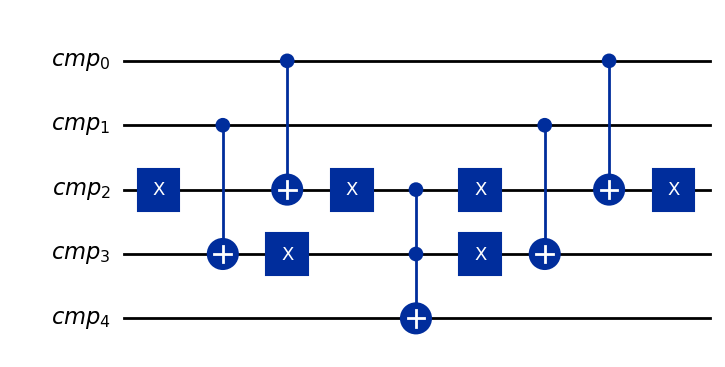

Instruction(name='Compare2', num_qubits=5, num_clbits=0, params=[])

In [19]:
compare_to_int(2)

## Recording the Conflicts
This piece of the oracle has required some design choices. In order to use fewer ancilla, we will need more repetitions of the comparison gates. We also set the initial conflict bit to 1 (TRUE) to indicate that there are no conflicts. This makes it simple to use the Toffoli gate (which is a logical AND when applied to a zeroed qubit) to record whether there is a conflict in a cumulative fashion. 

The oracle will proceed by area of the puzzle (row, column, square) and record the conflict in a dedicated conflict ancilla for each. Finally, a multi-controlled Z-gate will be used to mark the solution state.
 

### Area Circuit 

This circuit will return a wire (labeled areg below) that is 0 if there is a conflict in the area and 1 when there is no conflict. 
The remaining wires will be returned to their initial state. 
All of the creg wires and areg are assumed to be initialized to 0. 
The quantum registers correspond to the empty cells in the area. 
The circuit below is an example area circuit. We will loop through the areas below to construct our oracle gate for the sudoku circuit.

In [21]:
constraint_dict = puzzle_constraints(test_puzzle)[0]
max_comparisons = puzzle_constraints(test_puzzle)[1]
ancilla_count = max_comparisons + 2 # Two additional for the "current" comparison and final record
local_empty_cells = []
j = 0 # We're doing this for the first row right now
circuit_label = "Row0"
for i in range(puzzle_size**2): # This loop collects the empty cells in the area
    if (j,i) in empty_cells_fn(test_puzzle):
        local_empty_cells.append((j,i))
qreg = QuantumRegister(2*len(local_empty_cells),"x") #The empty cell registers for the local area. 
calcreg = AncillaRegister(2, "t") #Internal registers for the comparison gates. These are prepared as 0
creg = AncillaRegister(ancilla_count,"cf") # intermediate conflict recording wires. These are prepared as zero.

#We create the circuit that will track a conflict in the area
local_circuit =  QuantumCircuit(qreg,calcreg,creg, name = circuit_label)
local_circuit.x(creg[0]) # Set the test bit to 1 (TRUE) that there is no conflict found 
l = len(local_empty_cells)
reg_no = 1 # setting the index of the ancillary register to record the first comparison
for i in range(l):
    for entry in constraint_dict["row0"]: # Loops over all entries to compare against each empty cell.
        local_wires = [qreg[2*i], qreg[2*i+1],calcreg[0],calcreg[1],creg[0], creg[reg_no]]
        gate = compare_to_int(entry)
        local_circuit.append(gate,qargs = local_wires[:-1], cargs = [])
        if reg_no == 1:
            local_circuit.cx(creg[0],creg[reg_no]) # The first comparison is recorded 
        else:
            local_circuit.ccx(creg[0],creg[reg_no-1],creg[reg_no]) #We record this comparison cumulatively with the previous ones
        local_circuit.append(gate,qargs = local_wires[:-1], cargs = []) # The comparison bit is reset
        reg_no=reg_no+1
    for j in range(i+1,l): #loops over subsequent empty cells so that each pairwise comparison is done once.
        local_wires = [qreg[2*i], qreg[2*i+1],qreg[2*j], qreg[2*j+1],calcreg[0],calcreg[1],creg[0], creg[reg_no]]
        local_circuit.append(CompReg,qargs = local_wires[:-1],cargs = []) # Apply the pairwise comparison
        if reg_no == 1:
            local_circuit.cx(creg[0],creg[reg_no]) # The first comparison is recorded if there were no entries in the area
        else:
            local_circuit.ccx(creg[0],creg[reg_no-1],creg[reg_no]) #We record this comparison cumulatively with the previous ones
        local_circuit.append(CompReg,qargs = local_wires[:-1], cargs = []) # The comparison bit is reset
        reg_no=reg_no+1
reg_no=reg_no-1 #Go back one in the register count since we do not need to record another comparison
local_circuit.cx(creg[reg_no],creg[-1]) # Record 0 for states in which any of the comparisons gave a conflict and 1 for a candidate solution.
#Now we reset all but the last conflict recording wires by iterating backward through the gates.
for i in range(l)[::-1]:
    for j in range(i+1,l)[::-1]: #loops over subsequent empty cells so that each pairwise comparison is done once.
        local_wires = [qreg[2*i], qreg[2*i+1],qreg[2*j], qreg[2*j+1],calcreg[0],calcreg[1],creg[0], creg[reg_no]]
        local_circuit.append(CompReg,qargs = local_wires[:-1],cargs = []) # Apply the pairwise comparison
        if reg_no == 1:
            local_circuit.cx(creg[0],creg[reg_no]) # The first comparison is recorded if there were no entries in the area
        else:
            local_circuit.ccx(creg[0],creg[reg_no-1],creg[reg_no]) #We record this comparison cumulatively with the previous ones
        local_circuit.append(CompReg,qargs = local_wires[:-1], cargs = []) # The comparison bit is reset
        reg_no=reg_no-1 
    for entry in constraint_dict["row0"][::-1]: # Loops over all entries to compare against each empty cell.
        local_wires = [qreg[2*i], qreg[2*i+1],calcreg[0],calcreg[1],creg[0], creg[reg_no]]
        gate = compare_to_int(entry)
        local_circuit.append(gate,qargs = local_wires[:-1], cargs = [])
        if reg_no == 1:
            local_circuit.cx(creg[0],creg[reg_no]) # The first comparison is recorded 
        else:
            local_circuit.ccx(creg[0],creg[reg_no-1],creg[reg_no]) #We record this comparison cumulatively with the previous ones
        local_circuit.append(gate,qargs = local_wires[:-1], cargs = []) # The comparison bit is reset
        reg_no=reg_no-1
           

reg_no


0

### Example area circuit picture. 
You can see that the circuit resets all of the comparison wires so that they can be reused for all of the areas. There are some obvious simplifications, in that the last self-inverse comparison gate is repeated to start unrecording. These could be eliminated, and possibly other gates simplified, but this presentation makes the logic of the circuit explicit.

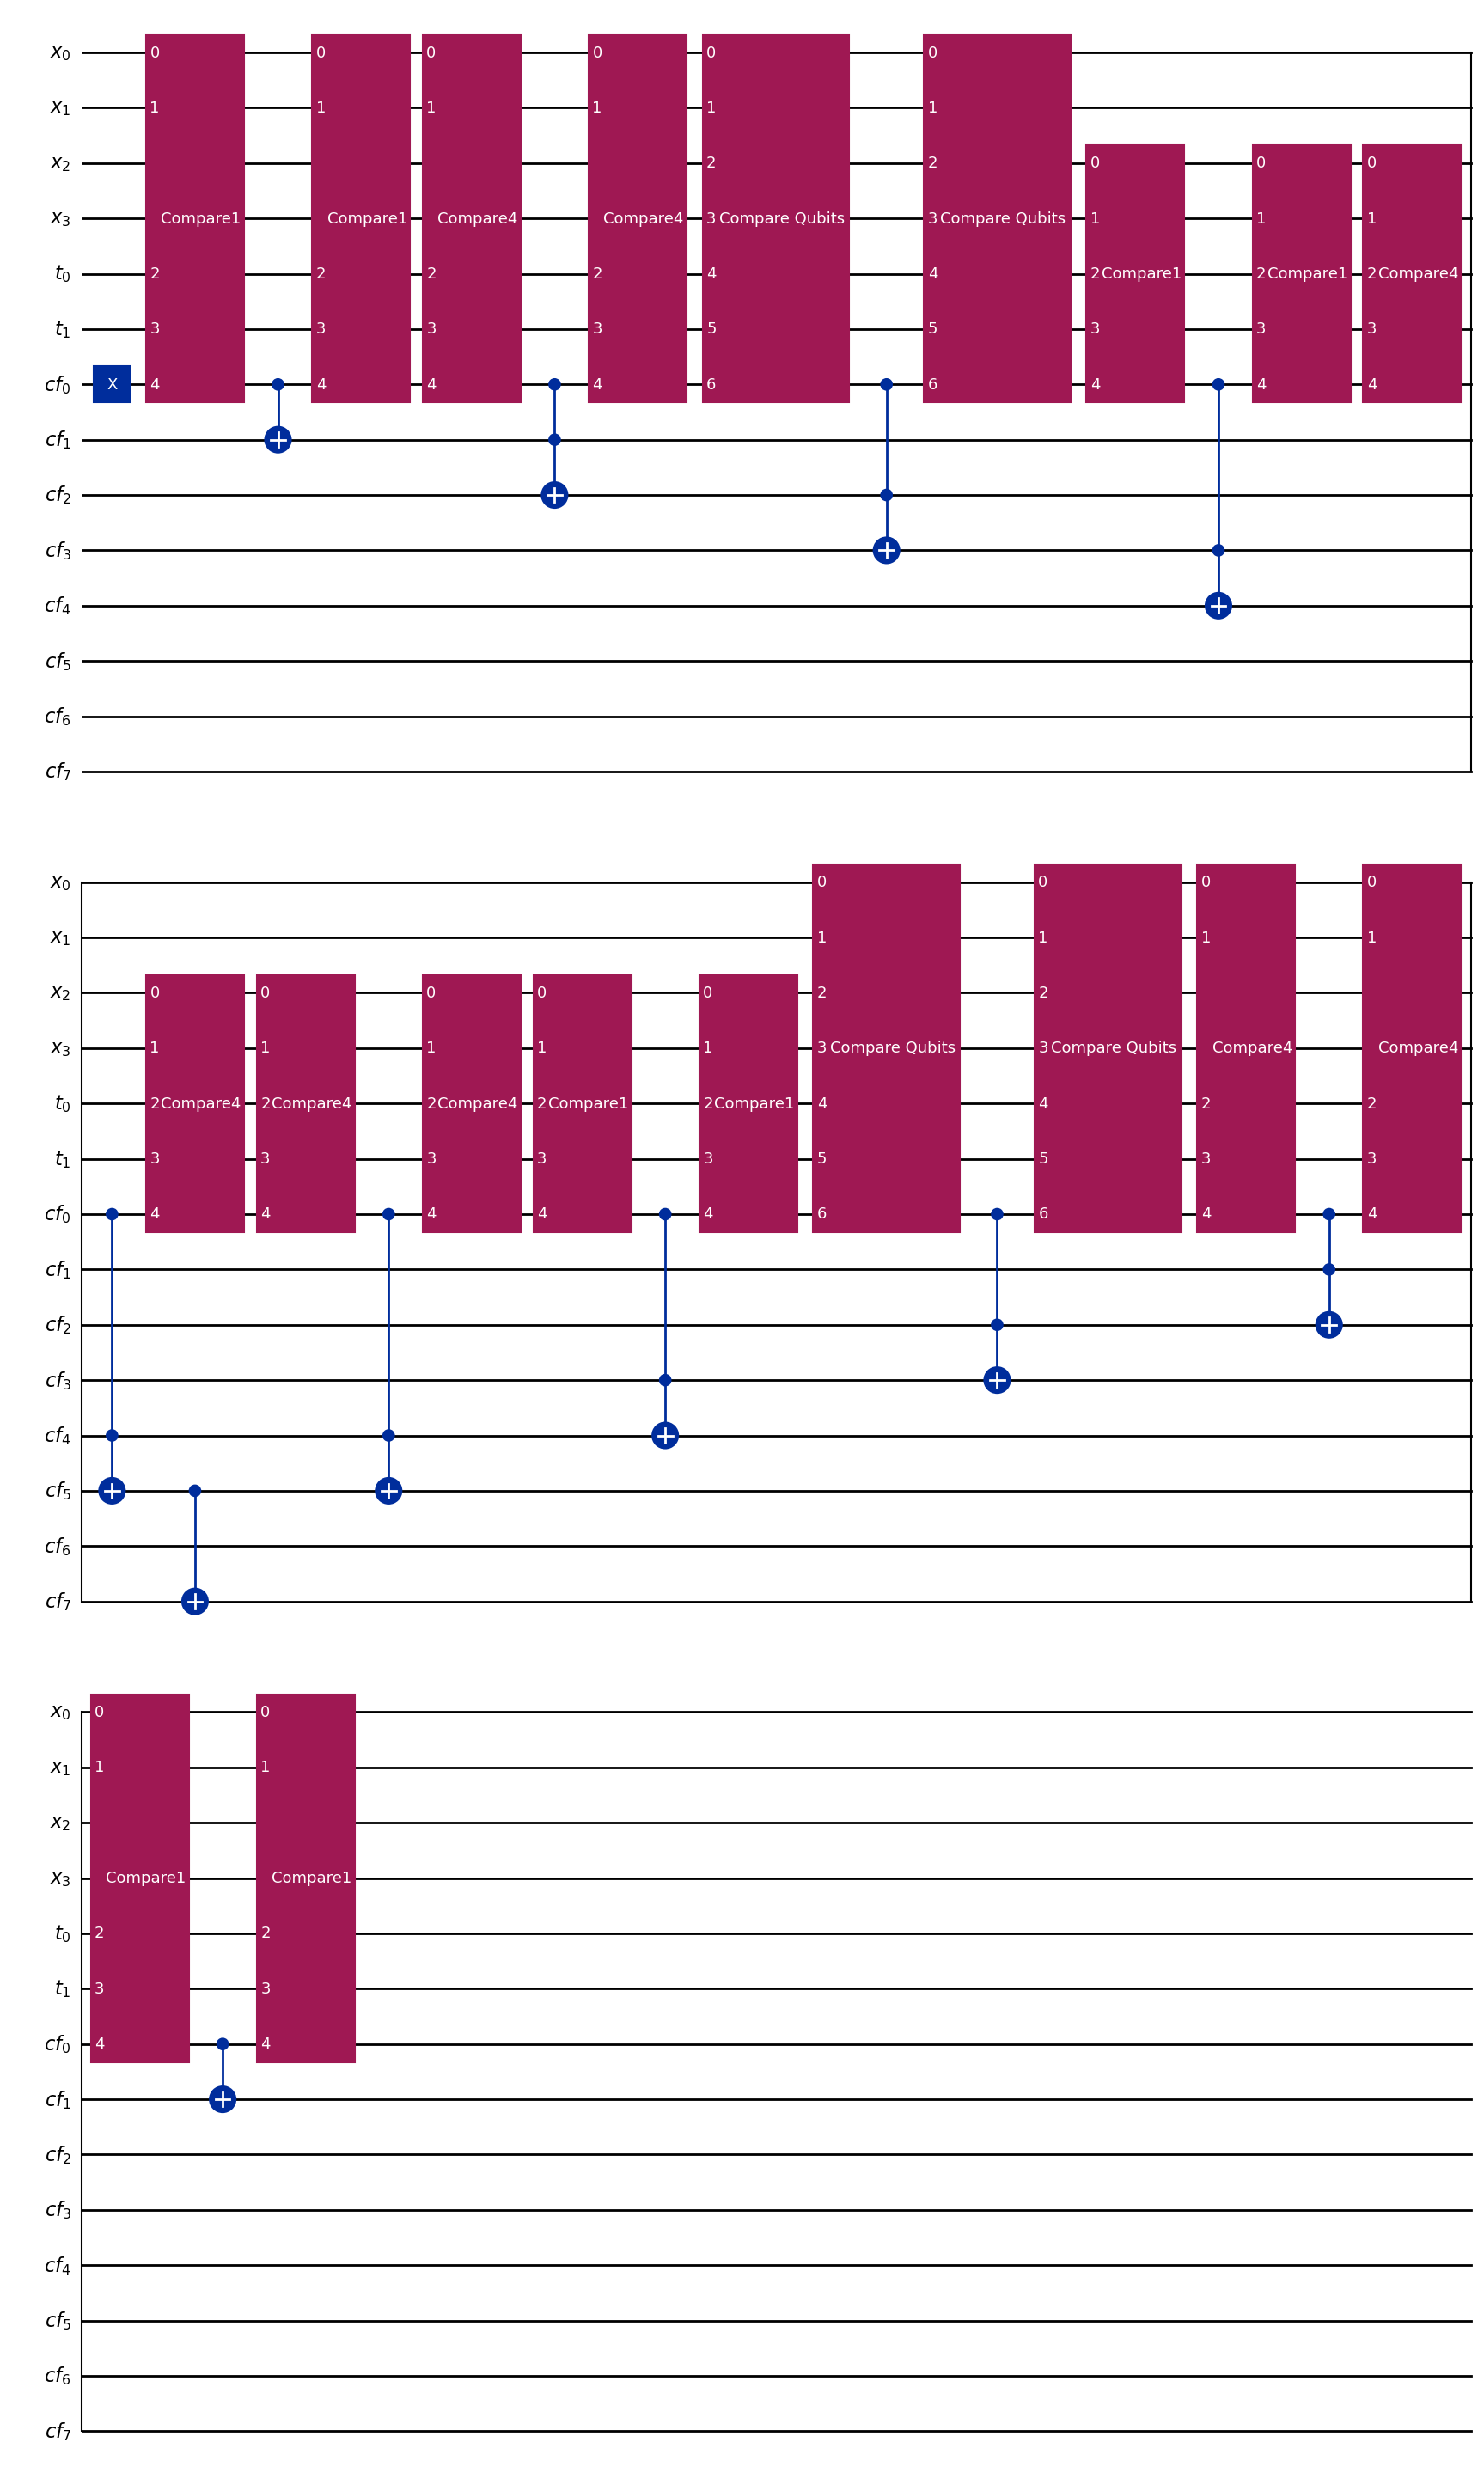

In [22]:
local_circuit.draw("mpl")

### Function for area oracle gate.
This function takes as input
- Number of empty cells *e*
- List of constraints (used numbers) for the area of length *c*
- String which names the area
And returns a gate which requires 
- 2 qubits per empty cell
- 2 ancillary wires for comparison calculations
- *ce + e(e-1)/2 + 2* ancillary wires all prepared to zero

After applying this gate, the last ancillary wire is marked with a 1 for states with no conflict and zero otherwise.



In [ ]:
def oracle_area_circuit_fn(empty_cell_no: int,constraints:list[int], area: str): #arguments are an empty cell register, a constraint dictionary, 
    comparisons = len(constraints)* empty_cell_no + (empty_cell_no-1)*empty_cell_no//2
    ancilla_count = comparisons + 2 # Two additional for the "current" comparison and final record
    # We're doing this for the first row right now
    circuit_label = area
    qreg = QuantumRegister(2*empty_cell_no,"x") #The empty cell registers for the local area. 
    calcreg = AncillaRegister(2, "t") #Internal registers for the comparison gates. These are prepared as 0
    creg = AncillaRegister(ancilla_count,"cf") # intermediate conflict recording wires. These are prepared as zero.

    #We create the circuit that will track a conflict in the area
    local_circuit =  QuantumCircuit(qreg,calcreg,creg, name = circuit_label)
    reg_no = 1 # setting the index of the ancillary register to record the first comparison
    for i in range(empty_cell_no):
        for entry in constraints: # Loops over all entries to compare against each empty cell.
            local_wires = [qreg[2*i], qreg[2*i+1],calcreg[0],calcreg[1],creg[0], creg[reg_no]]
            gate = compare_to_int(entry)
            local_circuit.append(gate,qargs = local_wires[:-1], cargs = [])
            if reg_no == 1:
                local_circuit.cx(creg[0],creg[reg_no]) # The first comparison is recorded 
            else:
                local_circuit.ccx(creg[0],creg[reg_no-1],creg[reg_no]) #We record this comparison cumulatively with the previous ones
            local_circuit.append(gate,qargs = local_wires[:-1], cargs = []) # The comparison bit is reset
            reg_no=reg_no+1
        for j in range(i+1,empty_cell_no): #loops over subsequent empty cells so that each pairwise comparison is done once.
            local_wires = [qreg[2*i], qreg[2*i+1],qreg[2*j], qreg[2*j+1],calcreg[0],calcreg[1],creg[0], creg[reg_no]]
            local_circuit.append(CompReg,qargs = local_wires[:-1],cargs = []) # Apply the pairwise comparison
            if reg_no == 1:
                local_circuit.cx(creg[0],creg[reg_no]) # The first comparison is recorded if there were no entries in the area
            else:
                local_circuit.ccx(creg[0],creg[reg_no-1],creg[reg_no]) #We record this comparison cumulatively with the previous ones
            local_circuit.append(CompReg,qargs = local_wires[:-1], cargs = []) # The comparison bit is reset
            reg_no=reg_no+1
    reg_no=reg_no-1 #Go back one in the register count since we do not need to record another comparison
    local_circuit.cx(creg[reg_no],creg[-1]) # Record 0 for states in which any of the comparisons gave a conflict and 1 for a candidate solution.
    #Now we reset all but the last conflict recording wires by iterating backward through the gates.
    for i in range(empty_cell_no)[::-1]:
        for j in range(i+1,empty_cell_no)[::-1]: #loops over subsequent empty cells so that each pairwise comparison is done once.
            local_wires = [qreg[2*i], qreg[2*i+1],qreg[2*j], qreg[2*j+1],calcreg[0],calcreg[1],creg[0], creg[reg_no]]
            local_circuit.append(CompReg,qargs = local_wires[:-1],cargs = []) # Apply the pairwise comparison
            if reg_no == 1:
                local_circuit.cx(creg[0],creg[reg_no]) # The first comparison is recorded if there were no entries in the area
            else:
                local_circuit.ccx(creg[0],creg[reg_no-1],creg[reg_no]) #We record this comparison cumulatively with the previous ones
            local_circuit.append(CompReg,qargs = local_wires[:-1], cargs = []) # The comparison bit is reset
            reg_no=reg_no-1 
        for entry in constraints[::-1]: # Loops over all entries to compare against each empty cell.
            local_wires = [qreg[2*i], qreg[2*i+1],calcreg[0],calcreg[1],creg[0], creg[reg_no]]
            gate = compare_to_int(entry)
            local_circuit.append(gate,qargs = local_wires[:-1], cargs = [])
            if reg_no == 1:
                local_circuit.cx(creg[0],creg[reg_no]) # The first comparison is recorded 
            else:
                local_circuit.ccx(creg[0],creg[reg_no-1],creg[reg_no]) #We record this comparison cumulatively with the previous ones
            local_circuit.append(gate,qargs = local_wires[:-1], cargs = []) # The comparison bit is reset
            reg_no=reg_no-1
    fig = local_circuit.draw("mpl")
    #display(fig)  #Only uncomment for testing. 
    return local_circuit.to_gate()            


### Example of testing the local area gate function.

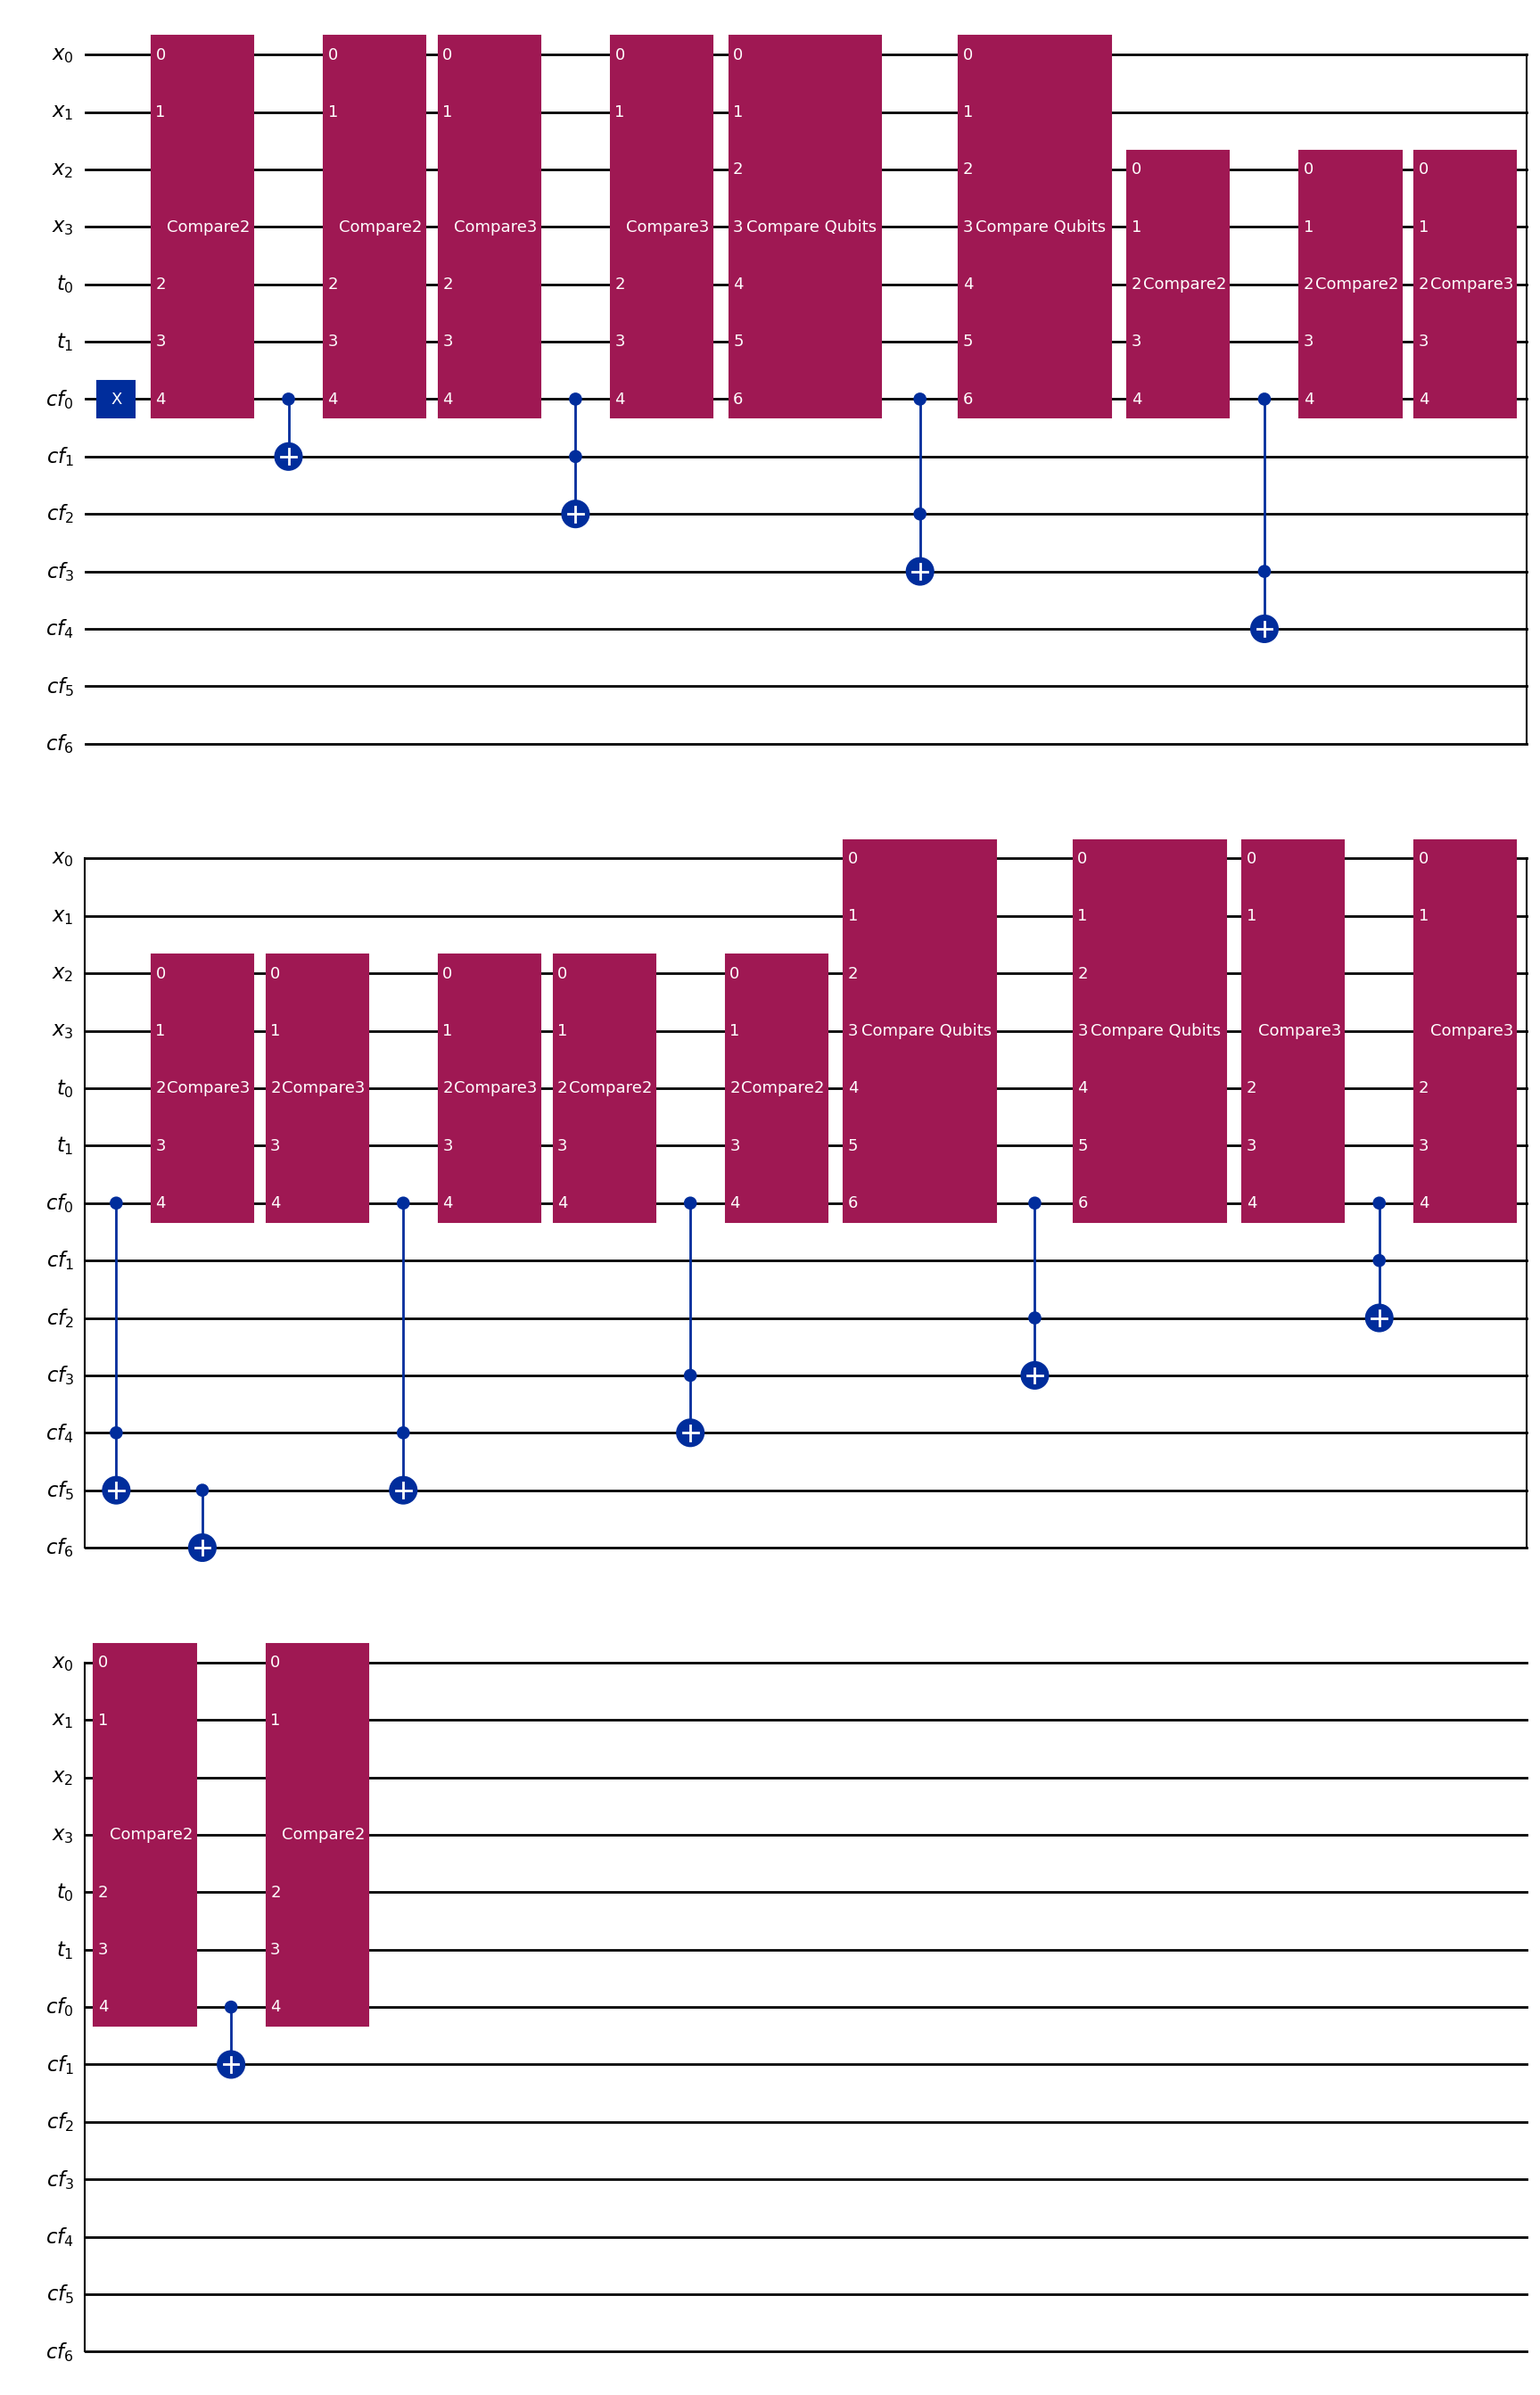

Instruction(name='TestArea', num_qubits=13, num_clbits=0, params=[])

In [44]:
oracle_area_circuit_fn(2,[2,3],"TestArea")

### Completing the Oracle gate
To Construct the Oracle gate, we use all of the tools we have built so far. Starting with a puzzle, we construct a sudoku circuit and iterate through the constraint regions (rows, columns, and squares), marking the potential solution states on ancillary bits for each area. The code below shows the construction on our test puzzle.

In [66]:

qc, empty_reg_dict, calc_reg, area_reg = build_sudoku_circuit(test_puzzle) #Build the circuit for the puzzle and unpack 
qc.x(calc_reg[2]) # This is the bit that detects a conflict. We initialize it to 1 (TRUE) to indicate no conflict. It will flip for conflicts, and be reset to its incoming state after each area gate.
constraint_by_area, empty_cell_by_area = area_dict_fn(test_puzzle,2) #Break down the puzzle by area
cfl_count = puzzle_constraints(test_puzzle)[1] + 3 #Number of calc wires in the circuit
area_counter = 0 #Counter for the area wires
#Now we iterate over the rows, columns, and squares to apply our area oracle to each one.
for area in constraint_by_area:
    c = len(constraint_by_area[area]) #Number of constraints for the area
    e = len(empty_cell_by_area[area]) #Number of empty cells in the area
    gate = oracle_area_circuit_fn(len(empty_cell_by_area[area]),constraint_by_area[area], area) #Build the local area circuit
    empty_cells = empty_cell_by_area[area] #Unpack the list of empty cells for iteration
        #We get the wires we need for the gate.
    area_wires = []
    calc_wire_no = c*e+e*(e-1)//2 +3
    for cell in empty_cells:
        area_wires.append(empty_reg_dict[cell][0])
        area_wires.append(empty_reg_dict[cell][1])
    for i in range(calc_wire_no):
            area_wires.append(calc_reg[i]) #calc_reg[0] and calc_reg[1] correspond to the t-wires in the comparison gates. calc_reg[2] is the main comparison bit. 
    area_wires.append(area_reg[area_counter])
    qc.append(gate,area_wires)
    area_counter = area_counter + 1
qc.h(calc_reg[2]) #We're using HXH=Z to apply the multicontrol Z gate 
control_wires = [area_reg[i] for i in range(12)]
qc.mcx(control_wires,calc_reg[2])
qc.h(calc_reg[2])






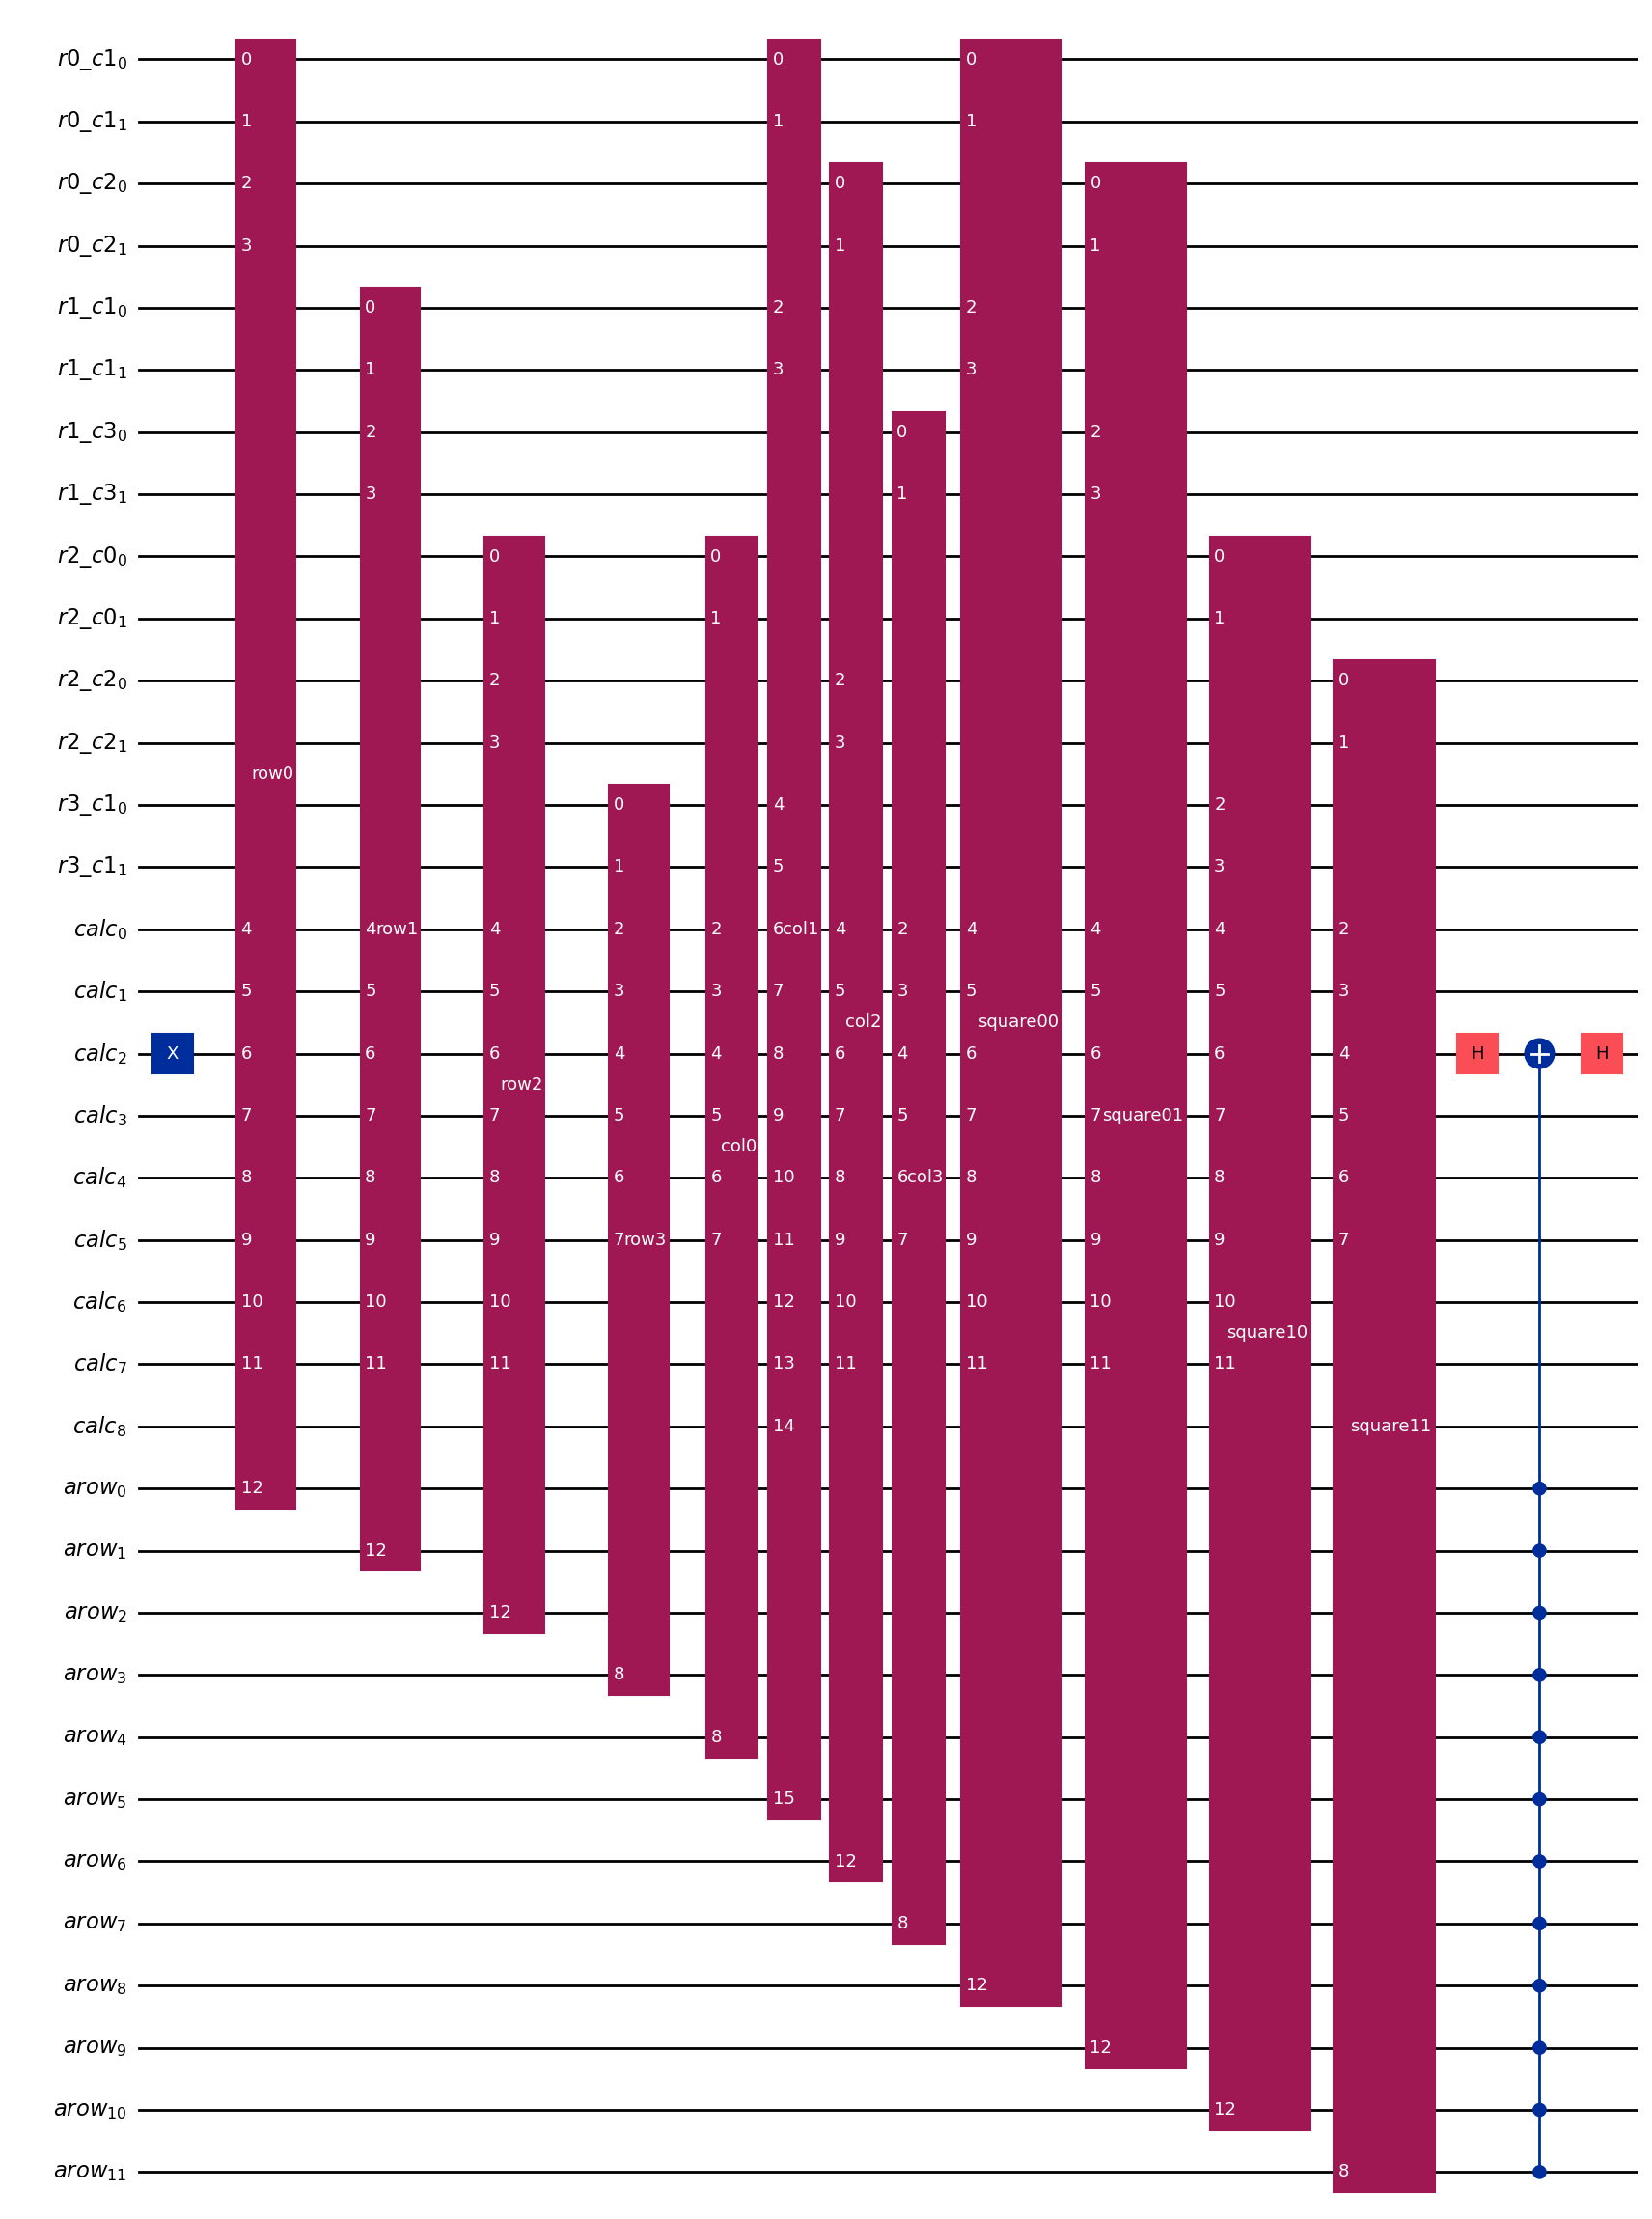

In [67]:
qc.draw("mpl")

### The Oracle gate
We express the code above as a fuction to create the oracle. The multicontrolled Z-gate will act on the comparison control bit, which is set to 1. This will change the sign of summand corresponding to the solution.

In [70]:
def oracle_gate_fn(puzzle: list[list[int]], size: int):
    qc, empty_reg_dict, calc_reg, area_reg = build_sudoku_circuit(test_puzzle) #Build the circuit for the puzzle and unpack 
    qc.x(calc_reg[2]) # This is the bit that detects a conflict. We initialize it to 1 (TRUE) to indicate no conflict. It will flip for conflicts, and be reset to its incoming state after each area gate.
    constraint_by_area, empty_cell_by_area = area_dict_fn(test_puzzle,2) #Break down the puzzle by area
    cfl_count = puzzle_constraints(test_puzzle)[1] + 3 #Number of calc wires in the circuit
    area_counter = 0 #Counter for the area wires
    #Now we iterate over the rows, columns, and squares to apply our area oracle to each one.
    for area in constraint_by_area:
        c = len(constraint_by_area[area]) #Number of constraints for the area
        e = len(empty_cell_by_area[area]) #Number of empty cells in the area
        gate = oracle_area_circuit_fn(len(empty_cell_by_area[area]),constraint_by_area[area], area) #Build the local area circuit
        empty_cells = empty_cell_by_area[area] #Unpack the list of empty cells for iteration
        #We get the wires we need for the gate.
        area_wires = []
        calc_wire_no = c*e+e*(e-1)//2 +3
        for cell in empty_cells:
            area_wires.append(empty_reg_dict[cell][0])
            area_wires.append(empty_reg_dict[cell][1])
        for i in range(calc_wire_no):
                area_wires.append(calc_reg[i]) #calc_reg[0] and calc_reg[1] correspond to the t-wires in the comparison gates. calc_reg[2] is the main comparison bit. 
        area_wires.append(area_reg[area_counter])
        qc.append(gate,area_wires)
        area_counter = area_counter + 1 
    qc.h(calc_reg[2]) #We're using HXH=Z to apply the multicontrol Z gate 
    control_wires = [area_reg[i] for i in range(12)]
    qc.mcx(control_wires,calc_reg[2])
    qc.h(calc_reg[2])
    return qc.to_gate()
        

## Grover's Search Algorithm
Now that we have marked the solution, we can apply Grover's algorithm to find it! We first construct the diffusion gate. Note that the number of times that we must repeat our diffusion gate will depend on the number of empty cells in the puzzle, so we calculate that next. Finally we construct the full circuit and apply it to our test puzzle.